In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('..')

In [2]:
test_indices = np.load('model_outputs/terra_test_indices.pkl', allow_pickle=True)
test_indices

array([ 8498, 15398,  8620, ..., 30403, 21243,  2732])

In [3]:
terra_modis_estimate = pd.read_pickle(f"data/OCEAN_terra_transformed_modo_targets.pkl")
terra_modis_estimate.describe()

,mTau470,mTau550,mTau660,mTau870
count,3.657500e+04,3.657500e+04,3.657500e+04,36575.000000
mean,3.695407e-08,9.202761e-07,4.173548e-08,0.000002
std,1.000014e+00,1.000021e+00,1.000004e+00,1.000016
min,-4.112963e+00,-3.541345e+00,-3.500248e+00,-3.774736
25%,-7.086595e-01,-7.157189e-01,-7.130946e-01,-0.694877
50%,-1.844988e-02,-2.018444e-02,-1.042525e-02,0.002054
75%,7.155086e-01,7.188818e-01,7.154244e-01,0.682332
max,3.657457e+00,3.536505e+00,3.505603e+00,3.604722


In [4]:
terra_y_test = pd.read_pickle('model_outputs/terra_y_test.pkl')
terra_y_test.describe()

,aTau470,aTau550,aTau660,aTau870
count,3658.000000,3658.000000,3658.000000,3658.000000
mean,0.017894,0.017421,0.017210,0.014069
std,1.005973,1.005352,1.002875,1.001527
min,-3.457691,-3.479602,-3.339459,-5.531823
25%,-0.696217,-0.692395,-0.685505,-0.664540
50%,0.004596,-0.003593,0.003828,-0.022601
75%,0.745450,0.730960,0.708410,0.673490
max,3.125156,3.180821,3.238946,3.185570


In [5]:
terra_mlp_out = pd.read_pickle('model_outputs/terra_mlp_out.pkl')
terra_mlp_out.describe()

,aTau470,aTau550,aTau660,aTau870
count,3658.000000,3658.000000,3658.000000,3658.000000
mean,0.040664,0.034804,0.030727,0.024748
std,0.956222,0.956195,0.952055,0.933108
min,-2.351692,-2.398227,-2.372031,-2.244537
25%,-0.703240,-0.696259,-0.679104,-0.648063
50%,-0.014635,-0.035274,-0.053897,-0.070548
75%,0.756881,0.752402,0.735276,0.656229
max,2.995283,3.090479,3.185079,3.245600


In [6]:
terra_edl_out_np = np.load('model_outputs/terra_edl_out_edl_param=0.1.npy')
terra_mu, terra_v, terra_alpha, terra_beta = tf.split(terra_edl_out_np, [terra_mlp_out.shape[1] for i in range(4)], axis=-1)
terra_var = np.sqrt(terra_beta / (terra_v * (terra_alpha - 1)))
terra_edl_out = pd.DataFrame(terra_mu.numpy(), columns=terra_mlp_out.columns)

2022-03-07 01:39:10.125855: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from kde import calc_kde2d
from aod_models import plot_kde2d, plot_linregress, plot_linregress_diff

Starting the 2D kernel density estimation with 3658 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


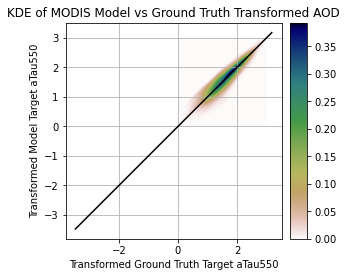

In [8]:
transformed_y_test = terra_y_test.aTau550
transformed_modis_y_test_aod = terra_modis_estimate.iloc[test_indices].mTau550
y_test_bins, out_bins_modis, P_modis = calc_kde2d(transformed_y_test, transformed_modis_y_test_aod)
plot_kde2d(y_test_bins, out_bins_modis, P_modis, Title='KDE of MODIS Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 3658 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


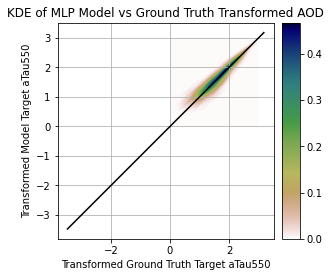

In [9]:
transformed_y_test = terra_y_test.aTau550
transformed_out_df = terra_mlp_out.aTau550
y_test_bins, out_bins, P = calc_kde2d(transformed_y_test, transformed_out_df)
plot_kde2d(y_test_bins, out_bins, P, Title='KDE of MLP Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 3658 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


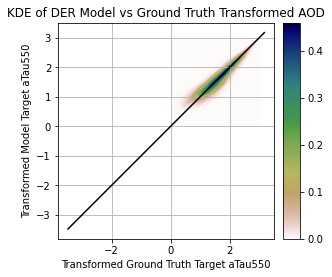

In [10]:
transformed_y_test = terra_y_test.aTau550
transformed_out_edl_df = terra_edl_out.aTau550
y_test_bins, out_edl_bins, P_edl = calc_kde2d(transformed_y_test, transformed_out_edl_df)
plot_kde2d(y_test_bins, out_edl_bins, P_edl, Title='KDE of DER Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

0.9240151451441715 -0.0029888500855262956 0.9181078574904118 0.0 0.006596900303584836
0.9181078574904118


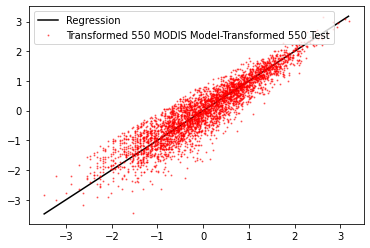

In [11]:
# MODIS lin reg
r = plot_linregress(transformed_y_test, transformed_modis_y_test_aod, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MODIS Model-Transformed 550 Test')
print(r)

0.8853446127072596 0.019380332571675693 0.9308588015985374 0.0 0.005747369982251062
0.9308588015985374


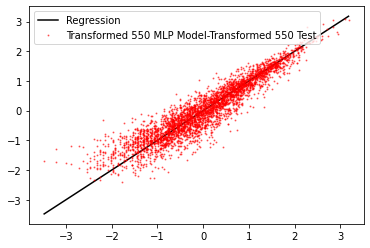

In [12]:
# MLP lin reg
r = plot_linregress(transformed_y_test, transformed_out_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MLP Model-Transformed 550 Test')
print(r)

0.8607603854690103 0.00894231818631827 0.9303879936361593 0.0 0.005608922767478078
0.9303879936361593


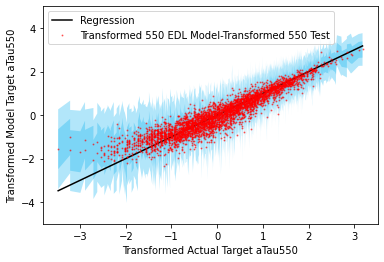

In [13]:
# EDL lin reg
n_stds = 4
std = np.minimum(np.sqrt(terra_var), 1e3)
r = plot_linregress(transformed_y_test, transformed_out_edl_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 EDL Model-Transformed 550 Test')
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1]), (transformed_out_edl_df[indices] + std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1]), (transformed_out_edl_df[indices] + 2*std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Actual Target aTau550')
plt.ylabel('Transformed Model Target aTau550')
plt.ylim([-5,5])
print(r)

0.8607603854690103 0.00894231818631827 0.9303879936361593 0.0 0.005608922767478078
[-0.38853693 -0.99356294  0.5084069  ... -0.17076856  1.4056972
  0.9033063 ]
0.9303879936361593


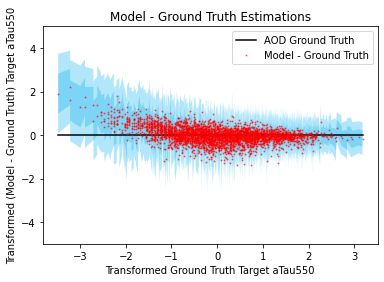

In [14]:
n_stds = 4
std = np.minimum(np.sqrt(terra_var), 1e3)
r = plot_linregress_diff(transformed_y_test.values, transformed_out_edl_df.values, np.linspace(transformed_y_test.min(), transformed_y_test.max()))
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + 2*std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Ground Truth Target aTau550')
plt.ylabel('Transformed (Model - Ground Truth) Target aTau550')
plt.legend(loc='best')
plt.ylim([-5,5])
print(r)

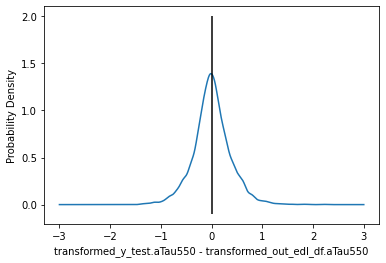

In [16]:
from sklearn.neighbors import KernelDensity
diff_transformed_aod_estimations = transformed_out_edl_df.to_numpy() - transformed_y_test.to_numpy()
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(diff_transformed_aod_estimations[:, np.newaxis])
X_plot = np.linspace(-3, 3, 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.xlabel('transformed_y_test.aTau550 - transformed_out_edl_df.aTau550')
plt.ylabel('Probability Density')
plt.vlines(0, ymin=-0.1, ymax=2, color='k')